In [14]:
%matplotlib inline

import sys
import os
import numpy as np
import pandas as pd
import xarray as xr
from matplotlib import pyplot as plt, animation, rc
from datetime import datetime, timedelta
from dateutil.parser import parse
from cartopy import crs, feature
import cmocean
import yaml

from IPython.display import Image
rc('animation', html='html5')

sys.path.append('/home/jvalenti/MOAD/analysis-jose/notebooks/parcels')
from OP_functions_biofilm import *

import geopy.distance 

In [15]:
# Define paths
local = 0 #Set to 0 when working on server
paths = path(local)
config='/home/jvalenti/MOAD/analysis-jose/OParcels/config3.yaml'

In [16]:
def load_config(config_yaml):
   with open(config_yaml) as f:
       config = yaml.safe_load(f)
   return config

In [17]:
param = load_config(config)
start = datetime(param['startdate']['year'], param['startdate']['month'], param['startdate']['day']) #Start date
Tmax = param['param']['length'] # Set Time length [days] 
duration = timedelta(days=Tmax)
dt = param['param']['dt'] #toggle between - or + to pick backwards or forwards 
N = param['param']['N'] # number of deploying locations
n = param['param']['n'] # 1000   # number of particles per location
dmin = param['param']['dmin'] #minimum depth
dd = param['param']['dd'] #max depth difference from dmin
name = param['file']['name'] #name output file

daterange = [start+timedelta(days=i) for i in range(Tmax)]
fn =  name + '_'.join(d.strftime('%Y%m%d')+'_1n' for d in [start, start+duration]) + '.nc'
outfile = os.path.join(paths['out'], fn)

In [18]:
Dat=xr.open_dataset(paths['coords'],decode_times=False)
outf_lat=Dat['nav_lat'][445,304]
outf_lon=Dat['nav_lon'][445,304]
clon, clat = [float(outf_lon)],[float(outf_lat)]

In [19]:
coords = xr.open_dataset(paths['coords'], decode_times=False)
mask = xr.open_dataset(paths['mask'])
ds = xr.open_dataset(outfile)

In [20]:
DS=ds.to_dataframe()
#ds2=ds.where(ds['time']==ds.time[0,0])
#sed=ds2.where(ds2.beached==3).dropna(how='all')
#colu=ds2.where(ds2.beached==0).dropna(how='all')

In [21]:
DSsed=DS[DS.beached==3.0]
DScol=DS[DS.beached==0.0]

In [22]:
Sedlon=np.array(DSsed.iloc[:,3])#.sort_values(by='time')
Sedlat=np.array(DSsed.iloc[:,2])#.sort_values(by='time')

#DScol=DScol.iloc[:,1:5].sort_values(by='time')
Collon=np.array(DScol.iloc[:,3])#.sort_values(by='time')
Collat=np.array(DScol.iloc[:,2])#.sort_values(by='time')

In [23]:
def distancia(lat2,lon2):
    R = 6371e3
    la1 = float(outf_lat) * math.pi/180
    la2 = lat2 * math.pi/180
    deltlat = (lat2-float(outf_lat)) * math.pi/180
    deltlon = (lon2-float(outf_lon)) * math.pi/180
    a = np.sin(deltlat/2) * np.sin(deltlat/2) + np.cos(la1) * np.cos(la2) * np.sin(deltlon/2) * np.sin(deltlon/2)
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    return R * c 
dcol = distancia(Collat,Collon)
dsink = distancia(Sedlat,Sedlon)

In [24]:
time=np.array(DScol.swaplevel(i=- 2, j=- 1, axis=0).time[0])
time2=np.array(DSsed.swaplevel(i=- 2, j=- 1, axis=0).time[223])

In [25]:
countime = [] 
for t in time:
    countime.append(len(DScol.time[DScol.time==t]))

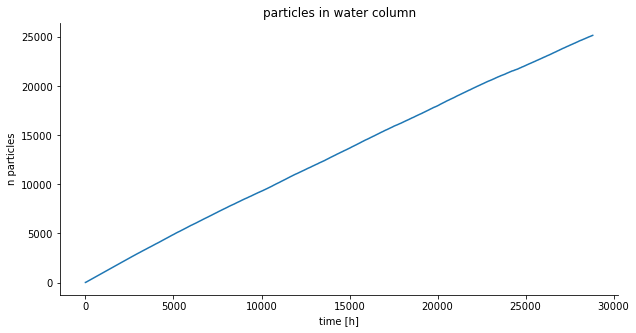

In [26]:
fig,ax=plt.subplots(1,figsize=(10,5))
plt.plot(countime)
plt.xlabel('time [h]')
plt.ylabel('n particles')
plt.title('particles in water column')
# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
np.savetxt("time2.csv", countime, delimiter=",")

Text(0.5, 1.0, 'Particles in the watercolumn')

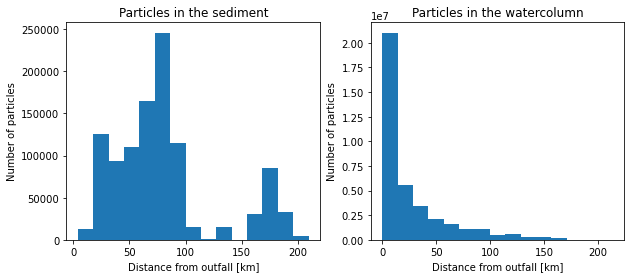

In [27]:
fig,axs=plt.subplots(1,2,figsize=(10,4))
axs[0].hist(dsink/1e3, bins = 15)
axs[0].set_xlabel('Distance from outfall [km]')
axs[0].set_ylabel('Number of particles')
axs[0].set_title('Particles in the sediment')

axs[1].hist(dcol/1e3, bins = 15)
axs[1].set_xlabel('Distance from outfall [km]')
axs[1].set_ylabel('Number of particles')
axs[1].set_title('Particles in the watercolumn')

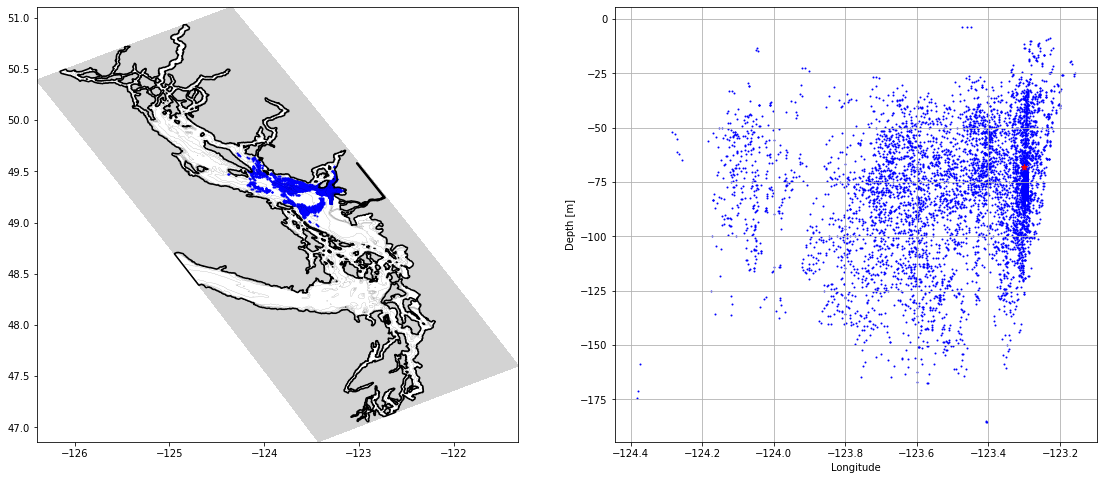

In [28]:
visuald(outfile,N,n,clon,clat,dmin,dd,300,302,local)

In [29]:
#profile(N,n,100,outfile,local)

In [30]:
# def outfilee(name):
#     # Set output file name.  Maybe change for each run
#     fn = name + '_'.join(d.strftime('%Y%m%d')+'_1n' for d in [start, start+duration]) + '.nc' 
#     return os.path.join(paths['out'], fn)

# fig,axs=plt.subplots(4,2,figsize=(10,20))
# outfile =  outfilee('f18summer')
# profile2(axs[0,0],N,n,length,outfile,local)
# visual2(axs[0,1],outfile,N,n,clon,clat,dmin,dd,-2,-1,local)
# outfile =  outfilee('f9summer')
# profile2(axs[1,0],N,n,length,outfile,local)
# visual2(axs[1,1],outfile,N,n,clon,clat,dmin,dd,-2,-1,local)
# outfile =  outfilee('f4summer')
# profile2(axs[2,0],N,n,length,outfile,local)
# visual2(axs[2,1],outfile,N,n,clon,clat,dmin,dd,-2,-1,local)
# outfile =  outfilee('f2summer')
# profile2(axs[3,0],N,n,length,outfile,local)
# visual2(axs[3,1],outfile,N,n,clon,clat,dmin,dd,-2,-1,local)
# #plt.savefig('summer.pdf')

In [31]:
#anim=mapanimation(outfile,N,n,clon,clat,1,0)
#anim

In [32]:
# fps=240
# anim = mapanimation(outfile,N,n,clon,clat,fps,local)
# f = r"/home/jvalenti/MOAD/animations/fibreS1.gif" 
# FFwriter = animation.FFMpegWriter()
# anim.save(f, writer = FFwriter)

In [33]:
# with open(f,'rb') as anim:
#    display(Image(anim.read()))